# Resnet50
## Import library

In [23]:
import os
import time
import platform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import chain
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.applications.vgg16 
import tensorflow.keras.applications.vgg19
from tensorflow.keras.applications import ResNet50
import tensorflow.keras.applications.resnet50
import tensorflow.keras.applications.xception
import tensorflow.keras.applications.inception_v3
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras import initializers, Model
from tensorflow.keras import regularizers

## Function definitions

In [24]:
def build_fileDatabases(data_dir):
    os.chdir(data_dir)
    fileDatabases = []
    classNames = []

    for dirpath,dirnames ,filenames in os.walk(data_dir):        
        if filenames:     
            if platform.system() == "Linux":
                path = dirpath.split('/')
            else:
                path = dirpath.split('\\')
        else:
            continue
    
        if path[-3][0] == '#': #Nazwy folderów poprzedzone znakime # nie będą zawarte w bazie danych
            #print('contains #')
            continue
    
        for i in range(len(path)):
            if path[i] == 'Left':# or path[i] == 'Right':
                className = path[i-2]
                classNames.append(className)
    
                filenames_images = []
    
                for i in range(len(filenames)):
                    if filenames[i][-3:] == 'jpg':              
                        filenames_images.append(os.path.join(dirpath,filenames[i]))
    
                fileDatabases.append(filenames_images) 

    classNumber = len(set(classNames))
    classDict = dict(zip(set(classNames),range(classNumber)))
    print('Słownik obiektów: \n',classDict)
    return fileDatabases, classDict, classNames

def read_images(fileDatabases, img_width, img_height):
    data = []  
    for i in range(len(fileDatabases)):
        data.append([])
        for j in range(len(fileDatabases[i])): 
            image = load_img(fileDatabases[i][j], target_size=(img_height, img_width))
            image = img_to_array(image)
            image = tensorflow.keras.applications.resnet50.preprocess_input(image)
            data[i].append(image)
                
    return data

def build_input_data(data, classDict, classNames, test_size,random_state):
    trainX = [] 
    trainY = []    
    #valX = [] 
    #valY = []     
    testX = [] 
    testY = []     
  
    for i in range(len(data)): 
        
        labels = []
        
        for j in range(len(data[i])):
            labels.append(classNames[i])
        
        (trainX_temp, testX_temp, trainY_temp, testY_temp) = train_test_split(data[i], labels,
     	test_size=test_size, random_state=random_state)
        testX.append(testX_temp)
        testY.append(testY_temp)
        
        #(trainX_temp, testX_temp, trainY_temp, testY_temp) = train_test_split(trainX_temp, trainY_temp,
     	#test_size=valid_size, random_state=random_state) 
        
        #valX.append(testX_temp)
        #valY.append(testY_temp)
        
        trainX.append(trainX_temp)
        trainY.append(trainY_temp)
        
    trainX = list(chain.from_iterable(trainX)) 
    #valX = list(chain.from_iterable(valX))
    testX = list(chain.from_iterable(testX))
    
    trainY_long = []
    #valY_long = []
    testY_long = []
    
    for i in range(len(trainY)):
        for j in range(len(trainY[i])):
            trainY_long.append(classDict.get(trainY[i][j]))
            
    #for i in range(len(valY)):
    #    for j in range(len(valY[i])):
    #        valY_long.append(classDict.get(valY[i][j]))
            
    for i in range(len(testY)):
        for j in range(len(testY[i])):
            testY_long.append(classDict.get(testY[i][j]))
            
    trainX = np.array(trainX, dtype="float")
    print('Number of images in train set: {}'.format(trainX.shape[0]))
    #valX = np.array(valX, dtype="float")
    #print('Number of images in  validation set: {}'.format(valX.shape[0]))
    testX = np.array(testX, dtype="float")
    print('Number of images in test set: {}'.format(testX.shape[0]))
    trainY = np.array(trainY_long)
    print('Number of labels in train set: {}'.format(trainY.shape[0]))
    #valY = np.array(valY_long)
    #print('Number of labels in validation set: {}'.format(valY.shape[0]))
    testY = np.array(testY_long)
    print('Number of labels in test set: {}'.format(testY.shape[0]))
    
    trainY_cat = to_categorical(trainY)
    #valY_cat = to_categorical(valY)
    testY_cat = to_categorical(testY)
    
    return trainX, testX, trainY_cat, testY_cat # valX, , valY_cat                        

## Path creation

In [25]:
if platform.system() == "Linux":
    parentDir = "/home/cv/Models"
    modelsDir = '/home/cv/AlliedRecording1'
else:
    parentDir = "C:\\Users\\stann\\Spyder_projects\\Models"
    modelsDir = 'C:\\AlliedRecording1'

## Training parameters

In [26]:
model_name = "ResNet50"
img_height = 224
img_width = 224
batch_size = 32
test_size = 0.2
rotation_range=15
width_shift_range=0.1
height_shift_range=0.1
shear_range=0.1
zoom_range=0.1 #0.1
horizontal_flip=True
vertical_flip=True
fill_mode='nearest'
epochs = 200

## Build train / test sets

In [27]:
random_state = 1000
fileDatabases, classDict, classNames = build_fileDatabases(modelsDir)
data = read_images(fileDatabases, img_width, img_height)
trainX, testX, trainY_cat, testY_cat = build_input_data(data, classDict, classNames, 0.2, random_state) 

Słownik obiektów: 
 {'usb': 0, 'Auxxx': 1, 'wentylator': 2, '2xUSB': 3, 'wiatrak': 4, 'plytka': 5, 'cewka': 6, 'wyswietlacz': 7, 'wykladzina': 8, 'piny': 9, 'zlacze': 10}
Number of images in train set: 3172
Number of images in test set: 822
Number of labels in train set: 3172
Number of labels in test set: 822


## Model compilaton

In [28]:
K.clear_session() 
classNumber = len(trainY_cat[0])
core = ResNet50(input_shape=(img_height,img_width,3),weights='imagenet',include_top=False, classes=classNumber)

for layer in core.layers:
    layer.trainable = False
            
i = Input([img_height, img_width, 3])
x = core(i)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)  
x = Dense(classNumber,activation='softmax')(x)
model = Model(inputs=[i], outputs=[x])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])  

## Model training

In [29]:
test = 1
folderPath = os.path.join(parentDir,model_name+str(test))
if os.path.isdir(folderPath):
    shutil.rmtree(folderPath)       
os.makedirs(folderPath)

checkPointPath = os.path.join(folderPath,"checkpoint")
#earlyStopping = EarlyStopping(monitor = 'accuracy', patience = 15)
modelCheckpoint = ModelCheckpoint(checkPointPath, monitor = 'val_loss',save_best_only=True,save_weights_only=True)  
callbacks_list = [modelCheckpoint]  #earlyStopping,
  
imgGen_train = ImageDataGenerator(rotation_range=rotation_range, width_shift_range=width_shift_range,height_shift_range=height_shift_range,
                          shear_range=shear_range,zoom_range=zoom_range,horizontal_flip=horizontal_flip,fill_mode=fill_mode)
imgGen_train.fit(trainX)

start = time.time()
hist = model.fit(imgGen_train.flow(trainX,trainY_cat,batch_size = batch_size),
                    validation_data= (testX,testY_cat), 
                    epochs=epochs,verbose=1, callbacks=callbacks_list)
end = time.time()
elapsedTime = end - start

print('Training time: {}'.format(elapsedTime))

model.load_weights(checkPointPath)
modelPath = os.path.join(folderPath,"model")
historyPath = os.path.join(folderPath,"history.npy")
model.save(modelPath)
np.save(historyPath,hist.history)

#loss, accuracy = model.evaluate(trainX,trainY_cat,verbose=1)
#print('Accuracy in train set: {0:5.2f}'.format(accuracy))



Epoch 1/200
100/100 [==============================] - 25s 221ms/step - loss: 2.9043 - accuracy: 0.5435 - val_loss: 0.7083 - val_accuracy: 0.7543
Epoch 2/200
100/100 [==============================] - 21s 207ms/step - loss: 0.5651 - accuracy: 0.8146 - val_loss: 0.8250 - val_accuracy: 0.7847
Epoch 3/200
100/100 [==============================] - 21s 207ms/step - loss: 0.4742 - accuracy: 0.8490 - val_loss: 0.3688 - val_accuracy: 0.8747
Epoch 4/200
100/100 [==============================] - 21s 208ms/step - loss: 0.4353 - accuracy: 0.8663 - val_loss: 0.3961 - val_accuracy: 0.8832
Epoch 5/200
100/100 [==============================] - 21s 208ms/step - loss: 0.3454 - accuracy: 0.8919 - val_loss: 0.4271 - val_accuracy: 0.8662
Epoch 6/200
100/100 [==============================] - 21s 208ms/step - loss: 0.2252 - accuracy: 0.9234 - val_loss: 0.3731 - val_accuracy: 0.8771
Epoch 7/200
100/100 [==============================] - 21s 208ms/step - loss: 0.2767 - accuracy: 0.9139 - val_loss: 0.4839 -

Epoch 57/200
100/100 [==============================] - 21s 207ms/step - loss: 0.1075 - accuracy: 0.9713 - val_loss: 0.1958 - val_accuracy: 0.9562
Epoch 58/200
100/100 [==============================] - 21s 206ms/step - loss: 0.0854 - accuracy: 0.9741 - val_loss: 0.2079 - val_accuracy: 0.9513
Epoch 59/200
100/100 [==============================] - 21s 207ms/step - loss: 0.0787 - accuracy: 0.9779 - val_loss: 0.2640 - val_accuracy: 0.9465
Epoch 60/200
100/100 [==============================] - 21s 207ms/step - loss: 0.0921 - accuracy: 0.9748 - val_loss: 0.1517 - val_accuracy: 0.9599
Epoch 61/200
100/100 [==============================] - 21s 206ms/step - loss: 0.0792 - accuracy: 0.9782 - val_loss: 0.2034 - val_accuracy: 0.9404
Epoch 62/200
100/100 [==============================] - 21s 207ms/step - loss: 0.1218 - accuracy: 0.9675 - val_loss: 0.2011 - val_accuracy: 0.9428
Epoch 63/200
100/100 [==============================] - 21s 208ms/step - loss: 0.0749 - accuracy: 0.9814 - val_loss: 0

100/100 [==============================] - 21s 207ms/step - loss: 0.0519 - accuracy: 0.9864 - val_loss: 0.1295 - val_accuracy: 0.9684
Epoch 168/200
100/100 [==============================] - 21s 207ms/step - loss: 0.0491 - accuracy: 0.9855 - val_loss: 0.1587 - val_accuracy: 0.9647
Epoch 169/200
100/100 [==============================] - 21s 208ms/step - loss: 0.0371 - accuracy: 0.9893 - val_loss: 0.1922 - val_accuracy: 0.9489
Epoch 170/200
100/100 [==============================] - 21s 207ms/step - loss: 0.0268 - accuracy: 0.9896 - val_loss: 0.1160 - val_accuracy: 0.9672
Epoch 171/200
100/100 [==============================] - 21s 208ms/step - loss: 0.0268 - accuracy: 0.9921 - val_loss: 0.0935 - val_accuracy: 0.9818
Epoch 172/200
100/100 [==============================] - 21s 208ms/step - loss: 0.0302 - accuracy: 0.9912 - val_loss: 0.1396 - val_accuracy: 0.9745
Epoch 173/200
100/100 [==============================] - 21s 207ms/step - loss: 0.0432 - accuracy: 0.9883 - val_loss: 0.0958 -

C:\Users\stann\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Model accuracy

In [30]:
loss, accuracy = model.evaluate(testX,testY_cat,verbose=1)
print('Accuracy in test set: {0:5.4f}'.format(accuracy))

start = time.time()
model.predict(trainX)
end = time.time()    
exec_time = end - start
print('Execution time: {}'.format(exec_time))

26/26 [==============================] - 1s 54ms/step - loss: 0.0553 - accuracy: 0.9866
Accuracy in test set: 0.9866
Execution time: 6.904592514038086


## Learning curves

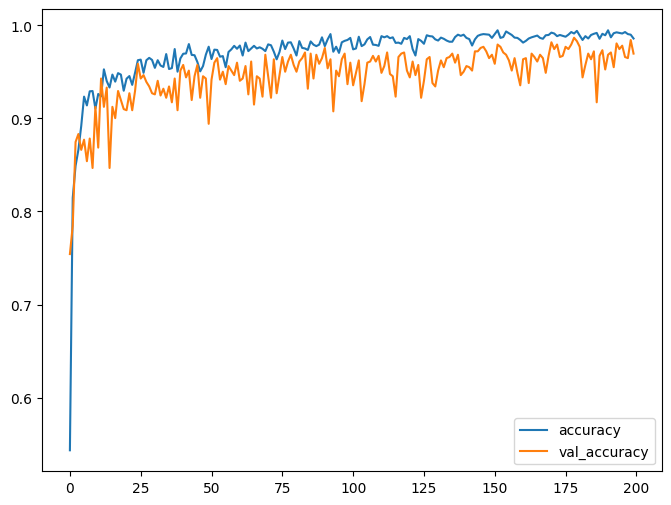

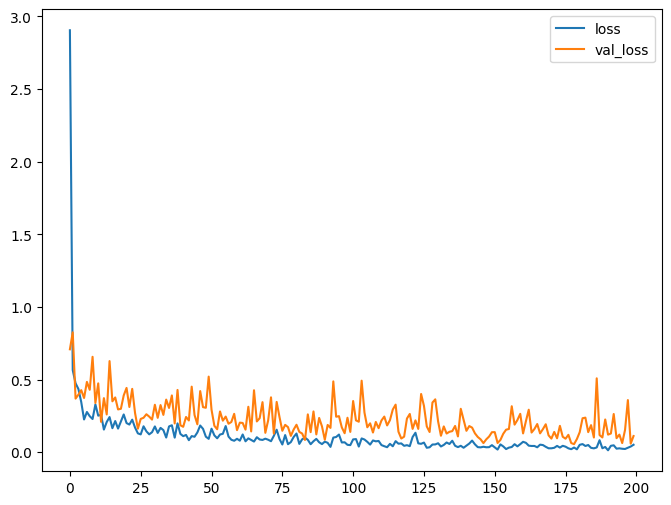

In [31]:
accuracyPlot = plt.figure()
plt.close('all')
plt.figure(1, figsize=(8,6))
plt.plot(hist.history['accuracy'],label = 'accuracy')
plt.plot(hist.history['val_accuracy'],label = 'val_accuracy')
plt.legend()
#plt.savefig('PartClassification/AccuracyNet1.png', dpi=300)

plt.figure(2, figsize=(8,6))
plt.plot(hist.history['loss'],label = 'loss')
plt.plot(hist.history['val_loss'],label = 'val_loss')
plt.legend()
#plt.savefig('PartClassification/LossNet1.png', dpi=300)
plt.show()

## Confusion matrix

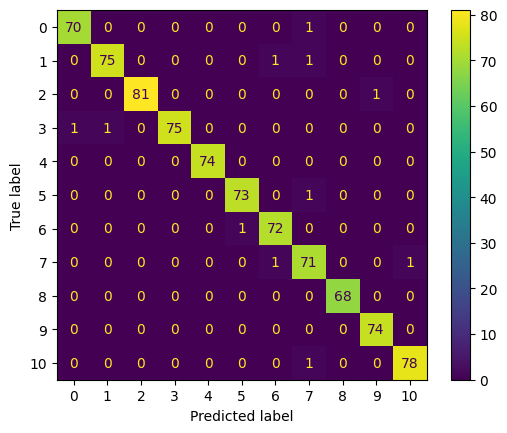

In [32]:
predictY = model.predict(testX).argmax(axis=1)
testY = np.argmax(testY_cat, axis=-1)
conf_matrix = confusion_matrix(testY,predictY)
ConfusionMatrixDisplay.from_predictions(testY,predictY)

### Test 2

In [33]:
#random_state = 1000
#fileDatabases, classDict, classNames = build_fileDatabases(modelsDir)
#data = read_images(fileDatabases, img_width, img_height)
#trainX, testX, trainY_cat, testY_cat = build_input_data(data, classDict, classNames, 0.2, random_state) 

In [34]:
K.clear_session() 
classNumber = len(trainY_cat[0])
core = ResNet50(input_shape=(img_height,img_width,3),weights='imagenet',include_top=False, classes=classNumber)

for layer in core.layers:
    layer.trainable = False
            
i = Input([img_height, img_width, 3])
x = core(i)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)  
x = Dense(classNumber,activation='softmax')(x)
model = Model(inputs=[i], outputs=[x])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])  

In [35]:
test = 2
folderPath = os.path.join(parentDir,model_name+str(test))
if os.path.isdir(folderPath):
    shutil.rmtree(folderPath)       
os.makedirs(folderPath)

checkPointPath = os.path.join(folderPath,"checkpoint")
#earlyStopping = EarlyStopping(monitor = 'accuracy', patience = 15)
modelCheckpoint = ModelCheckpoint(checkPointPath, monitor = 'val_loss',save_best_only=True,save_weights_only=True)  
callbacks_list = [modelCheckpoint]  #earlyStopping,
  
imgGen_train = ImageDataGenerator(rotation_range=rotation_range, width_shift_range=width_shift_range,height_shift_range=height_shift_range,
                          shear_range=shear_range,zoom_range=zoom_range,horizontal_flip=horizontal_flip,fill_mode=fill_mode)
imgGen_train.fit(trainX)

start = time.time()
hist = model.fit(imgGen_train.flow(trainX,trainY_cat,batch_size = batch_size),
                    validation_data= (testX,testY_cat), 
                    epochs=epochs,verbose=1, callbacks=callbacks_list)
end = time.time()
elapsedTime = end - start

print('Training time: {}'.format(elapsedTime))

model.load_weights(checkPointPath)
modelPath = os.path.join(folderPath,"model")
historyPath = os.path.join(folderPath,"history.npy")
model.save(modelPath)
np.save(historyPath,hist.history)

Epoch 1/200
100/100 [==============================] - 25s 226ms/step - loss: 2.3114 - accuracy: 0.4341 - val_loss: 1.1679 - val_accuracy: 0.5742
Epoch 2/200
100/100 [==============================] - 21s 210ms/step - loss: 1.0164 - accuracy: 0.6230 - val_loss: 0.8887 - val_accuracy: 0.6727
Epoch 3/200
100/100 [==============================] - 21s 208ms/step - loss: 0.7970 - accuracy: 0.6920 - val_loss: 0.9604 - val_accuracy: 0.6594
Epoch 4/200
100/100 [==============================] - 21s 209ms/step - loss: 0.7446 - accuracy: 0.7185 - val_loss: 0.7099 - val_accuracy: 0.7311
Epoch 5/200
100/100 [==============================] - 21s 210ms/step - loss: 0.6228 - accuracy: 0.7714 - val_loss: 0.6467 - val_accuracy: 0.7749
Epoch 6/200
100/100 [==============================] - 21s 209ms/step - loss: 0.4973 - accuracy: 0.8105 - val_loss: 0.5466 - val_accuracy: 0.8066
Epoch 7/200
100/100 [==============================] - 21s 210ms/step - loss: 0.4691 - accuracy: 0.8294 - val_loss: 0.4208 -

Epoch 57/200
100/100 [==============================] - 21s 209ms/step - loss: 0.0978 - accuracy: 0.9707 - val_loss: 0.1788 - val_accuracy: 0.9440
Epoch 58/200
100/100 [==============================] - 21s 212ms/step - loss: 0.0662 - accuracy: 0.9779 - val_loss: 0.1664 - val_accuracy: 0.9416
Epoch 59/200
100/100 [==============================] - 21s 210ms/step - loss: 0.0714 - accuracy: 0.9770 - val_loss: 0.3034 - val_accuracy: 0.9282
Epoch 60/200
100/100 [==============================] - 21s 211ms/step - loss: 0.0942 - accuracy: 0.9726 - val_loss: 0.1409 - val_accuracy: 0.9526
Epoch 61/200
100/100 [==============================] - 21s 210ms/step - loss: 0.0836 - accuracy: 0.9764 - val_loss: 0.1912 - val_accuracy: 0.9465
Epoch 62/200
100/100 [==============================] - 21s 209ms/step - loss: 0.1016 - accuracy: 0.9716 - val_loss: 0.2054 - val_accuracy: 0.9440
Epoch 63/200
100/100 [==============================] - 21s 210ms/step - loss: 0.0735 - accuracy: 0.9786 - val_loss: 0

100/100 [==============================] - 21s 210ms/step - loss: 0.0499 - accuracy: 0.9864 - val_loss: 0.0697 - val_accuracy: 0.9818
Epoch 168/200
100/100 [==============================] - 21s 211ms/step - loss: 0.0292 - accuracy: 0.9915 - val_loss: 0.0888 - val_accuracy: 0.9745
Epoch 169/200
100/100 [==============================] - 21s 210ms/step - loss: 0.0442 - accuracy: 0.9893 - val_loss: 0.1700 - val_accuracy: 0.9489
Epoch 170/200
100/100 [==============================] - 21s 210ms/step - loss: 0.1129 - accuracy: 0.9726 - val_loss: 0.1555 - val_accuracy: 0.9538
Epoch 171/200
100/100 [==============================] - 21s 209ms/step - loss: 0.0536 - accuracy: 0.9849 - val_loss: 0.1898 - val_accuracy: 0.9550
Epoch 172/200
100/100 [==============================] - 21s 210ms/step - loss: 0.0291 - accuracy: 0.9918 - val_loss: 0.0783 - val_accuracy: 0.9745
Epoch 173/200
100/100 [==============================] - 21s 210ms/step - loss: 0.0489 - accuracy: 0.9858 - val_loss: 0.1082 -

C:\Users\stann\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [36]:
loss, accuracy = model.evaluate(testX,testY_cat,verbose=1)
print('Accuracy in test set: {0:5.4f}'.format(accuracy))

start = time.time()
model.predict(trainX)
end = time.time()    
exec_time = end - start
print('Execution time: {}'.format(exec_time))

26/26 [==============================] - 1s 56ms/step - loss: 0.0564 - accuracy: 0.9842
Accuracy in test set: 0.9842
Execution time: 6.734065771102905


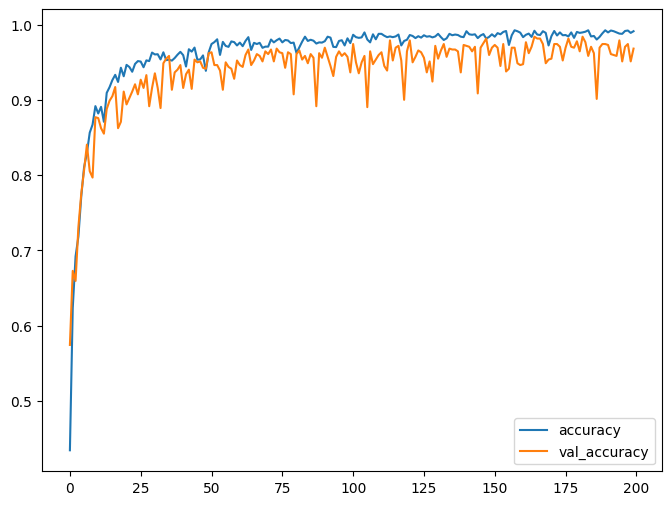

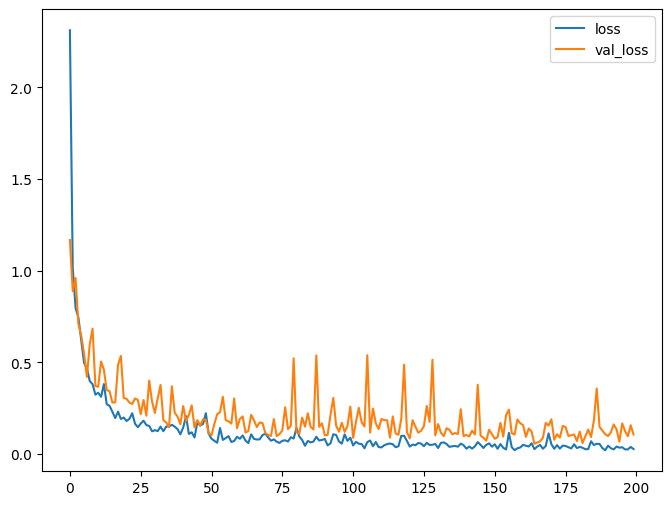

In [37]:
accuracyPlot = plt.figure()
plt.close('all')
plt.figure(1, figsize=(8,6))
plt.plot(hist.history['accuracy'],label = 'accuracy')
plt.plot(hist.history['val_accuracy'],label = 'val_accuracy')
plt.legend()
#plt.savefig('PartClassification/AccuracyNet1.png', dpi=300)

plt.figure(2, figsize=(8,6))
plt.plot(hist.history['loss'],label = 'loss')
plt.plot(hist.history['val_loss'],label = 'val_loss')
plt.legend()
#plt.savefig('PartClassification/LossNet1.png', dpi=300)
plt.show()

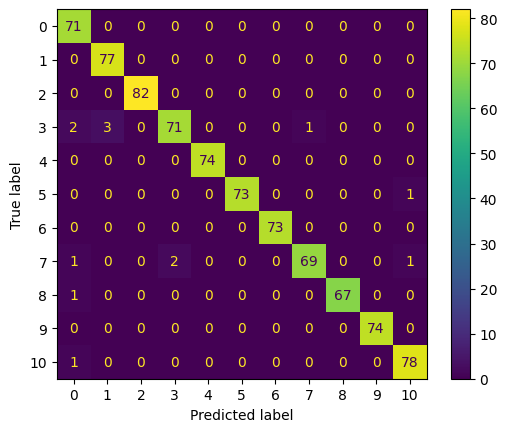

In [38]:
predictY = model.predict(testX).argmax(axis=1)
testY = np.argmax(testY_cat, axis=-1)
conf_matrix = confusion_matrix(testY,predictY)
ConfusionMatrixDisplay.from_predictions(testY,predictY)

### Test 3

In [39]:
#random_state = 1000
#fileDatabases, classDict, classNames = build_fileDatabases(modelsDir)
#data = read_images(fileDatabases, img_width, img_height)
#trainX, testX, trainY_cat, testY_cat = build_input_data(data, classDict, classNames, 0.2, random_state) 

In [40]:
K.clear_session() 
classNumber = len(trainY_cat[0])
core = ResNet50(input_shape=(img_height,img_width,3),weights='imagenet',include_top=False, classes=classNumber)

for layer in core.layers:
    layer.trainable = False
            
i = Input([img_height, img_width, 3])
x = core(i)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = Dense(64,activation='relu')(x)  
x = Dense(classNumber,activation='softmax')(x)
model = Model(inputs=[i], outputs=[x])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])  

In [41]:
test = 3
folderPath = os.path.join(parentDir,model_name+str(test))
if os.path.isdir(folderPath):
    shutil.rmtree(folderPath)       
os.makedirs(folderPath)

checkPointPath = os.path.join(folderPath,"checkpoint")
#earlyStopping = EarlyStopping(monitor = 'accuracy', patience = 15)
modelCheckpoint = ModelCheckpoint(checkPointPath, monitor = 'val_loss',save_best_only=True,save_weights_only=True)  
callbacks_list = [modelCheckpoint]  #earlyStopping,
  
imgGen_train = ImageDataGenerator(rotation_range=rotation_range, width_shift_range=width_shift_range,height_shift_range=height_shift_range,
                          shear_range=shear_range,zoom_range=zoom_range,horizontal_flip=horizontal_flip,fill_mode=fill_mode)
imgGen_train.fit(trainX)

start = time.time()
hist = model.fit(imgGen_train.flow(trainX,trainY_cat,batch_size = batch_size),
                    validation_data= (testX,testY_cat), 
                    epochs=epochs,verbose=1, callbacks=callbacks_list)
end = time.time()
elapsedTime = end - start

print('Training time: {}'.format(elapsedTime))

model.load_weights(checkPointPath)
modelPath = os.path.join(folderPath,"model")
historyPath = os.path.join(folderPath,"history.npy")
model.save(modelPath)
np.save(historyPath,hist.history)

Epoch 1/200
100/100 [==============================] - 24s 221ms/step - loss: 1.9477 - accuracy: 0.5801 - val_loss: 0.9391 - val_accuracy: 0.6959
Epoch 2/200
100/100 [==============================] - 21s 212ms/step - loss: 0.6449 - accuracy: 0.7840 - val_loss: 0.6273 - val_accuracy: 0.7968
Epoch 3/200
100/100 [==============================] - 21s 209ms/step - loss: 0.4829 - accuracy: 0.8395 - val_loss: 0.4651 - val_accuracy: 0.8394
Epoch 4/200
100/100 [==============================] - 21s 210ms/step - loss: 0.4219 - accuracy: 0.8616 - val_loss: 0.3644 - val_accuracy: 0.8735
Epoch 5/200
100/100 [==============================] - 21s 211ms/step - loss: 0.4187 - accuracy: 0.8622 - val_loss: 0.4250 - val_accuracy: 0.8601
Epoch 6/200
100/100 [==============================] - 21s 211ms/step - loss: 0.3029 - accuracy: 0.8982 - val_loss: 0.4028 - val_accuracy: 0.8917
Epoch 7/200
100/100 [==============================] - 21s 211ms/step - loss: 0.3504 - accuracy: 0.8900 - val_loss: 0.4337 -

Epoch 57/200
100/100 [==============================] - 21s 210ms/step - loss: 0.1000 - accuracy: 0.9691 - val_loss: 0.1552 - val_accuracy: 0.9659
Epoch 58/200
100/100 [==============================] - 21s 210ms/step - loss: 0.0870 - accuracy: 0.9764 - val_loss: 0.2771 - val_accuracy: 0.9392
Epoch 59/200
100/100 [==============================] - 21s 211ms/step - loss: 0.1271 - accuracy: 0.9682 - val_loss: 0.2615 - val_accuracy: 0.9526
Epoch 60/200
100/100 [==============================] - 21s 211ms/step - loss: 0.1219 - accuracy: 0.9669 - val_loss: 0.2789 - val_accuracy: 0.9489
Epoch 61/200
100/100 [==============================] - 21s 211ms/step - loss: 0.1144 - accuracy: 0.9713 - val_loss: 0.1866 - val_accuracy: 0.9611
Epoch 62/200
100/100 [==============================] - 21s 212ms/step - loss: 0.0802 - accuracy: 0.9754 - val_loss: 0.2212 - val_accuracy: 0.9501
Epoch 63/200
100/100 [==============================] - 21s 210ms/step - loss: 0.1330 - accuracy: 0.9688 - val_loss: 0

100/100 [==============================] - 21s 209ms/step - loss: 0.0941 - accuracy: 0.9789 - val_loss: 0.0860 - val_accuracy: 0.9745
Epoch 168/200
100/100 [==============================] - 21s 210ms/step - loss: 0.0484 - accuracy: 0.9874 - val_loss: 0.0921 - val_accuracy: 0.9757
Epoch 169/200
100/100 [==============================] - 21s 210ms/step - loss: 0.0410 - accuracy: 0.9880 - val_loss: 0.0743 - val_accuracy: 0.9805
Epoch 170/200
100/100 [==============================] - 21s 210ms/step - loss: 0.0347 - accuracy: 0.9912 - val_loss: 0.0704 - val_accuracy: 0.9830
Epoch 171/200
100/100 [==============================] - 21s 211ms/step - loss: 0.0256 - accuracy: 0.9902 - val_loss: 0.0895 - val_accuracy: 0.9793
Epoch 172/200
100/100 [==============================] - 21s 211ms/step - loss: 0.0349 - accuracy: 0.9902 - val_loss: 0.1158 - val_accuracy: 0.9708
Epoch 173/200
100/100 [==============================] - 21s 211ms/step - loss: 0.0284 - accuracy: 0.9912 - val_loss: 0.0485 -

C:\Users\stann\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [42]:
loss, accuracy = model.evaluate(testX,testY_cat,verbose=1)
print('Accuracy in test set: {0:5.4f}'.format(accuracy))

start = time.time()
model.predict(trainX)
end = time.time()    
exec_time = end - start
print('Execution time: {}'.format(exec_time))

26/26 [==============================] - 1s 55ms/step - loss: 0.0485 - accuracy: 0.9903
Accuracy in test set: 0.9903
Execution time: 6.779654026031494


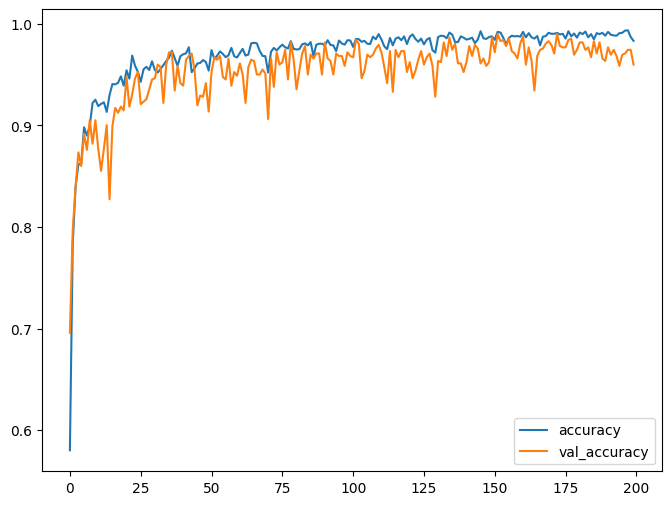

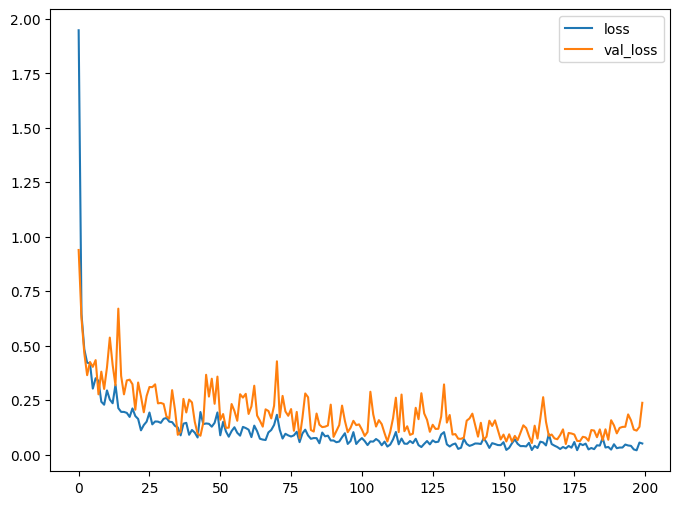

In [43]:
accuracyPlot = plt.figure()
plt.close('all')
plt.figure(1, figsize=(8,6))
plt.plot(hist.history['accuracy'],label = 'accuracy')
plt.plot(hist.history['val_accuracy'],label = 'val_accuracy')
plt.legend()
#plt.savefig('PartClassification/AccuracyNet1.png', dpi=300)

plt.figure(2, figsize=(8,6))
plt.plot(hist.history['loss'],label = 'loss')
plt.plot(hist.history['val_loss'],label = 'val_loss')
plt.legend()
#plt.savefig('PartClassification/LossNet1.png', dpi=300)
plt.show()

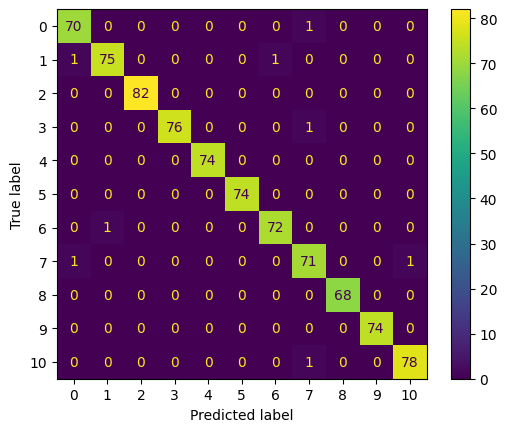

In [44]:
predictY = model.predict(testX).argmax(axis=1)
testY = np.argmax(testY_cat, axis=-1)
conf_matrix = confusion_matrix(testY,predictY)
ConfusionMatrixDisplay.from_predictions(testY,predictY)